### Edgar Moises Hernandez-Gonzalez
#### 05/03/20-25/03/20
#### Clasificacion de imagenes motoras en EEG con CNN-3D, CNN-2D + LSTM, CNN-2D + GRU y ConvLSTM2D
##### Caracteristicas = Escalogramas CWT (4D)
##### 2 canales C3 y C4
##### 5 ejecuciones independientes

#### CNN-3D
##### Sujeto 1
##### Accuracy = 47.92%
##### Kappa = 0.3056

#### CNN-2D + LSTM
##### Sujeto 1
##### Accuracy = 47.92%
##### Kappa = 0.3056

#### CNN-2D + GRU
##### Sujeto 1
##### Accuracy = 40.62%
##### Kappa = 0.2083

#### ConvLSTM2D
##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, MaxPool3D, Flatten, Dense, Dropout,
                                     TimeDistributed, Conv2D, MaxPool2D, LSTM,
                                     GRU, ConvLSTM2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [0]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [0]:
c3_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 7000:8000]
c4_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None).iloc[:, 11000:12000]
c3_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 7000:8000]
c4_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None).iloc[:, 11000:12000]

In [0]:
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [0]:
x_train = np.concatenate((c3_train, c4_train), axis=1)
x_test = np.concatenate((c3_test, c4_test), axis=1)

In [0]:
x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 2000)
(288, 2000)
(288, 1)
(288, 1)


In [0]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [0]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [0]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
#2 canales C3 y C4
def escalogramas(data):
  escalas = np.arange(1,129)
  dim = (224, 224) #ancho, alto
  datos = np.zeros((288,2,224,224))
  for i in range(data.shape[0]): #288 muestras
    for j in range(2): #2 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      resized = cv2.resize(abs(coef), dim, interpolation=cv2.INTER_AREA)
      datos[i,j] = resized
  return datos

In [0]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = escalogramas(x_train)

In [0]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = escalogramas(x_test)

In [0]:
print(x_train.shape)
print(x_test.shape)

(288, 2, 224, 224)
(288, 2, 224, 224)


In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

54.716573202611485
43.233727248541136
9.288589432297773e-09
8.365361435395828e-09


In [0]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 64.0
x_test /= 64.0

In [0]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))

0.85494643
0.675527
1.4513421e-10
1.3070878e-10


In [0]:
#convertir de 4D a 5D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], 1))

print(x_train.shape)
print(x_test.shape)

(288, 2, 224, 224, 1)
(288, 2, 224, 224, 1)


In [0]:
'''def CNN_3D():
  model = Sequential()
  model.add(Conv3D(32, (1,3,3), activation='relu',
                   input_shape=x_train.shape[1:]))
  model.add(MaxPool3D((1,2,2)))
  model.add(Conv3D(32, (1,3,3), activation='relu'))
  model.add(MaxPool3D((1,2,2)))
  model.add(Conv3D(32, (1,3,3), activation='relu'))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-6)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_LSTM_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu',)))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(8))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
'''def CNN_2D_GRU_TD():
  model = Sequential()
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'),
                            input_shape=x_train.shape[1:]))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu',)))
  model.add(TimeDistributed(MaxPool2D((2,2))))
  model.add(TimeDistributed(Flatten()))
  model.add(GRU(8))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model'''

In [0]:
def Conv_LSTM_2D():
  model = Sequential()
  model.add(ConvLSTM2D(16, (3,3), activation='relu', padding='same',
                       input_shape=x_train.shape[1:]))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(n_classes, activation='softmax'))
    
  optimizer = Adam(lr=1e-5)
  model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  return model

Iteration: 1
288/288 - 1s - loss: 1.2072 - acc: 0.4340
kappa:  0.24537037037037035
confusion matrix:
 [[34 29  5  4]
 [33 28  8  3]
 [11 16 28 17]
 [ 4  5 28 35]]


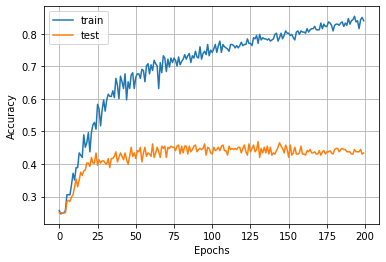

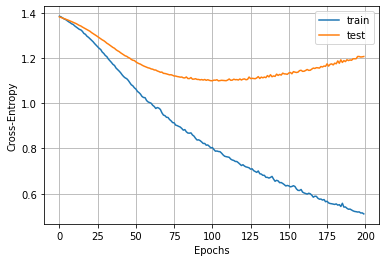

Iteration: 2
288/288 - 1s - loss: 1.3177 - acc: 0.3507
kappa:  0.1342592592592593
confusion matrix:
 [[20  0 23 29]
 [26  0 27 19]
 [ 0  0 39 33]
 [ 0  0 30 42]]


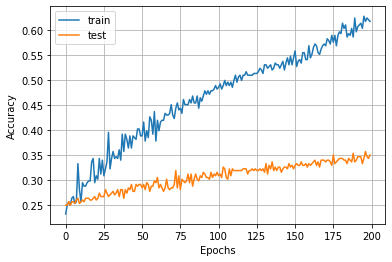

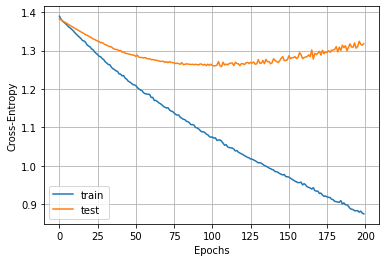


Resultados:
loss: [1.2071796655654907, 1.31766943136851]
accuracy: [0.4340278, 0.35069445]
kappa: [0.24537037037037035, 0.1342592592592593]


In [0]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(2):
  print("Iteration:", i+1)
    
  #model = CNN_3D()
  #model = CNN_2D_LSTM_TD()
  #model = CNN_2D_GRU_TD()
  model = Conv_LSTM_2D()

  history = model.fit(x_train, y_train, epochs=200, batch_size=18,
                      validation_data=(x_test, y_test), verbose=0)
    
  test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
  array_loss.append(test_loss)
  array_acc.append(test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [0]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 224, 224, 16)      9856      
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 16)      0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 802816)            0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                25690144  
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 132       
Total params: 25,700,132
Trainable params: 25,700,132
Non-trainable params: 0
_________________________________________________________________


In [0]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.3924
std: (+/- 0.0417)
Mean Kappa: 0.1898
std: (+/- 0.0556)
Max Accuracy: 0.4340
Max Kappa: 0.2454
